In [1]:
import os

from fastai.vision.all import *
from fastai.vision import *
from fastai.callback.data import OverSamplingCallback

import pandas as pd
import PIL

from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix

In [ ]:
# model and metrics to compare
precision_macro = Precision(average='macro')
recall_macro = Recall(average='macro')
precision_micro = Precision(average='micro')
recall_micro = RecallMulti(average='micro')
roc_auc = RocAuc()

epochs = 10
batch_size = 16
valid_pct = 0.25
resize = Resize(128)


### Compare Different Models
In this section I will compare different Image classification models with the datasets created.

In [ ]:
TRAIN_DATASET_PATH = "/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_1/train"
TEST_DATASET_PATH = "/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets/train_set_1/test"

In [ ]:
# lets bring the models and datasets 
available_models = {
    'alexnet': models.alexnet,
    'resnet34': models.resnet34,
    'resnet50': models.resnet50,
    'resnet101': models.resnet101,
    'resnet152': models.resnet152,
    'resnext50_32x4d': models.resnext50_32x4d,
    'resnext101_32x8d': models.resnext101_32x8d,
    'wide_resnet50_2': models.wide_resnet50_2,
    'wide_resnet101_2': models.wide_resnet101_2,
    'vgg16_bn': models.vgg16_bn,
    'vgg19_bn': models.vgg19_bn,
    'squeezenet1_1': models.squeezenet1_1,
    'densenet121': models.densenet121,
    'densenet169': models.densenet169,
    'densenet201': models.densenet201,
}

In [ ]:
# Custom transform
def custom_transform(size):
    return Resize(size, method="pad", pad_mode="zeros")


class RGB2HSV(Transform):
    def encodes(self, img: PILImage):
        return rgb2hsv(img)


dls = ImageDataLoaders.from_folder(
    path=TRAIN_DATASET_PATH,
    item_tfms=custom_transform(size=128),
    batch_tfms=[
        RGB2HSV(),
        *aug_transforms(size=128, flip_vert=True, max_rotate=10),
        Brightness(max_lighting=0.2, p=0.75),
        Contrast(max_lighting=0.2, p=0.75),
    ],
    bs=batch_size,
    valid_pct=valid_pct,
)

# Check a batch to see if transformations are applied correctly
dls.show_batch()

In [ ]:

precision_macro_fastai = Precision(average='macro')
recall_macro_fastai = Recall(average='macro')
roc_auc_fastai = RocAuc()

item_tfms=custom_transform(size=128),  # Resize and HSV transform
batch_tfms=[
    RGB2HSV(),
    *aug_transforms(size=128, flip_vert=True, max_rotate=10),
    Brightness(max_lighting=0.2, p=0.75),
    Contrast(max_lighting=0.2, p=0.75),
]

#Iterate over each model and train, then evaluate on the test set and save the results
results = []

for model_name, model_fn in available_models.items():
    print(f"Training model: {model_name}")
    
    model = vision_learner(
        dls=dls,
        arch=model_fn,
        metrics=[error_rate, precision_macro_fastai, recall_macro_fastai, roc_auc]
    )

    model.fine_tune(
        epochs=epochs
    )

    # Create the test DataLoader with the same transformations
    test_dl = dls.test_dl(get_image_files(TEST_DATASET_PATH), with_labels=True, 
                        item_tfms=item_tfms, batch_tfms=batch_tfms)

    # Evaluate on the test set
    preds, targs = model.get_preds(dl=test_dl)

    if targs is not None:
        pred_classes = preds.argmax(dim=1).numpy()
        true_classes = targs.numpy()

        precision = precision_score(true_classes, pred_classes, average='micro')
        recall = recall_score(true_classes, pred_classes, average='micro')
        
        # calc macro precision and recall
        precision_macro = precision_score(true_classes, pred_classes, average='macro')
        recall_macro = recall_score(true_classes, pred_classes, average='macro')
        
        accuracy = accuracy_score(true_classes, pred_classes)
        conf_matrix = confusion_matrix(true_classes, pred_classes)
        
        # Calculate precision and recall for each class
        precision_per_class = precision_score(true_classes, pred_classes, average=None)
        recall_per_class = recall_score(true_classes, pred_classes, average=None)
    else:
        precision_per_class = recall_per_class = precision = recall = accuracy = roc_auc = conf_matrix = None

    results.append({
        'model': model_name,
        'precision': precision,
        'recall': recall,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'precision_per_class': precision_per_class,
        'recall_per_class': recall_per_class,
        'accuracy': accuracy,
        'confusion_matrix': conf_matrix,
        'pred_classes': pred_classes,
        'true_classes': true_classes
        
    })
    
    print(f"Results for model {model_name}:")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"Precision Macro: {precision_macro}")
    print(f"Recall Macro: {recall_macro}")
    print(f"Accuracy: {accuracy}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(f"Precision per Class: {precision_per_class}")
    print(f"Recall per Class: {recall_per_class}")
    print("\n\n")


In [ ]:
results

### Plot the evaluation results

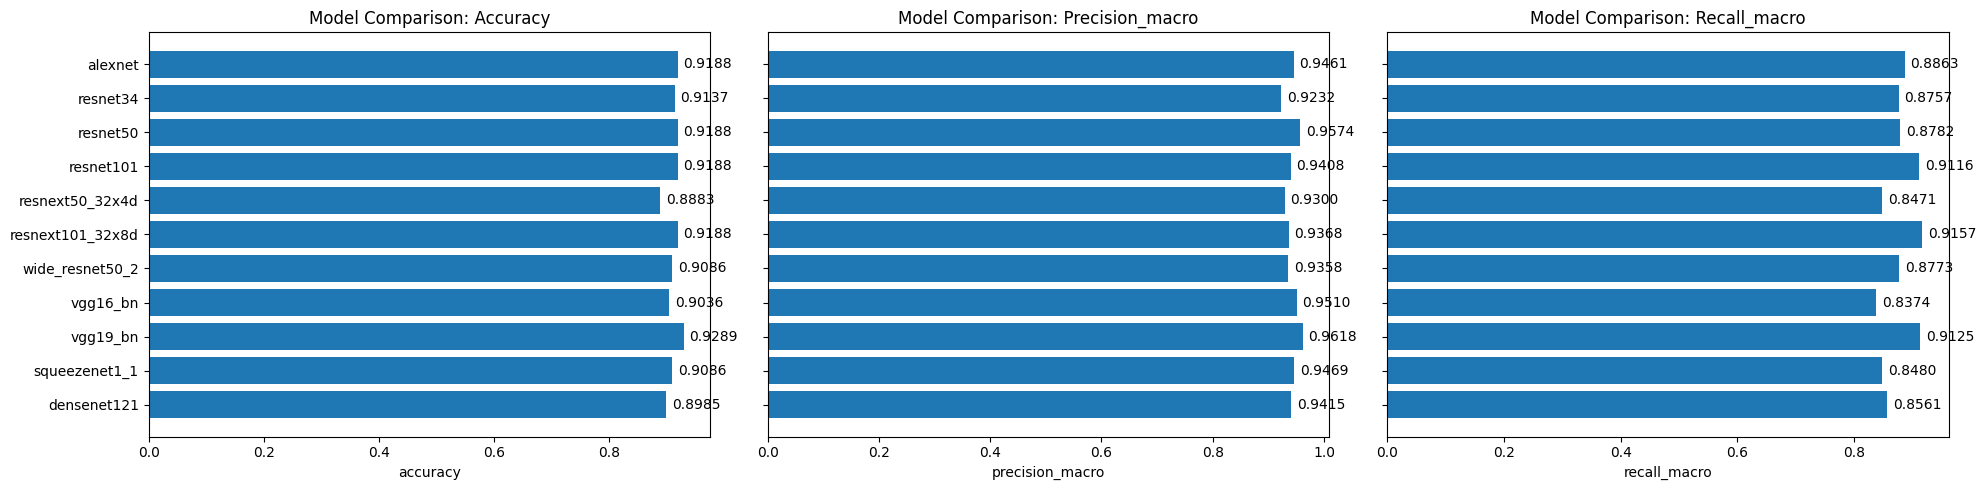

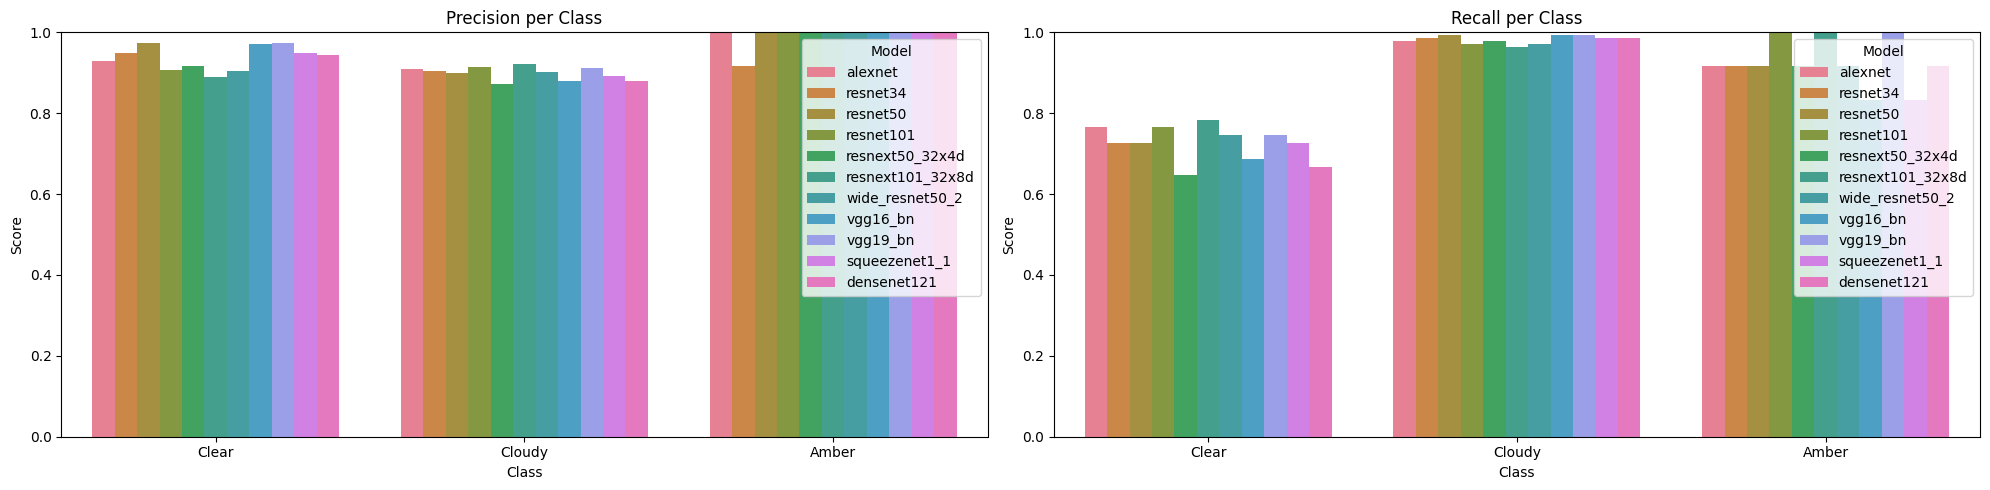

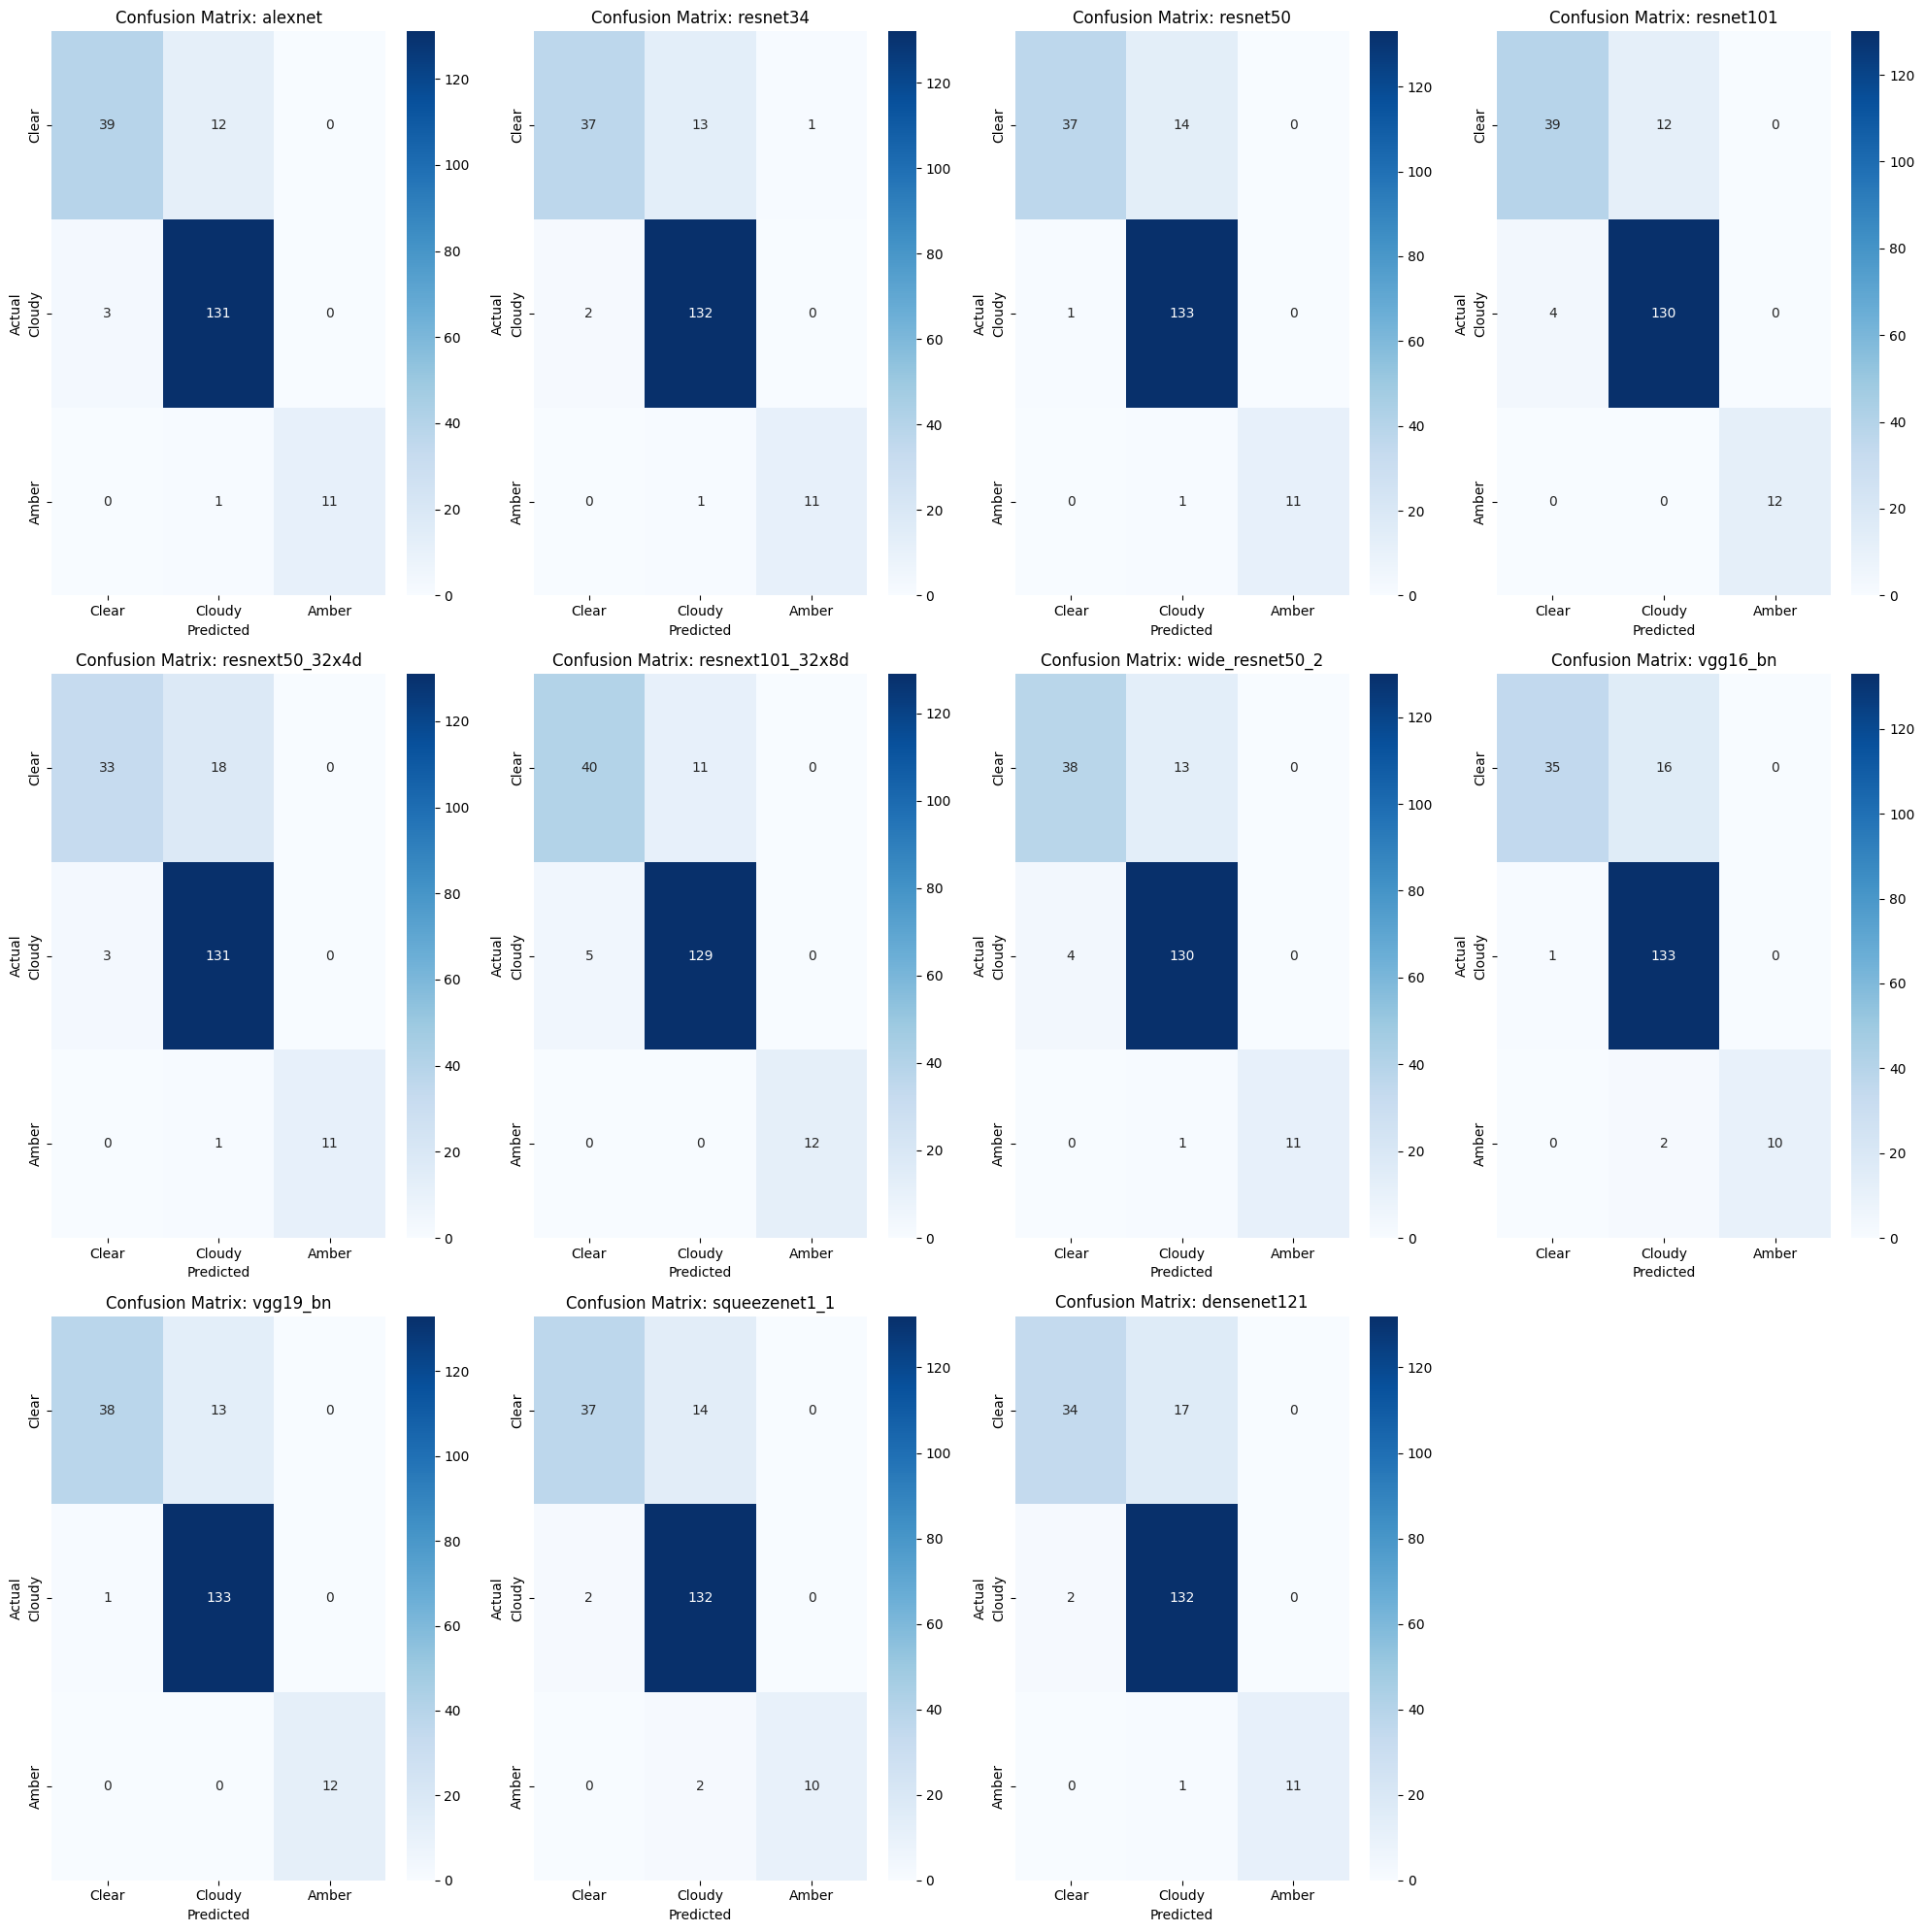

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix

# Assuming results is your list of dictionaries containing model results

# Define the new order of classes
class_mapping = {0: 2, 1: 0, 2: 1}  # Mapping from old to new class indices
inverse_class_mapping = {v: k for k, v in class_mapping.items()}  # Inverse mapping

# Function to reorder classes
def reorder_classes(true_classes, pred_classes, mapping):
    true_classes_reordered = np.array([mapping[cls] for cls in true_classes])
    pred_classes_reordered = np.array([mapping[cls] for cls in pred_classes])
    return true_classes_reordered, pred_classes_reordered

# Function to reorder confusion matrix
def reorder_confusion_matrix(cm, mapping):
    cm_reordered = cm[np.ix_([mapping[i] for i in range(len(mapping))],
                             [mapping[i] for i in range(len(mapping))])]
    return cm_reordered

# Reorder classes and update results
for result in results:
    true_classes = result['true_classes']
    pred_classes = result['pred_classes']
    true_classes_reordered, pred_classes_reordered = reorder_classes(true_classes, pred_classes, class_mapping)
    result['true_classes_reordered'] = true_classes_reordered
    result['pred_classes_reordered'] = pred_classes_reordered
    result['confusion_matrix_reordered'] = reorder_confusion_matrix(result['confusion_matrix'], inverse_class_mapping)

# Function to calculate precision and recall for each class
def calculate_class_metrics(results):
    for result in results:
        true_classes = result['true_classes_reordered']
        pred_classes = result['pred_classes_reordered']

        result['precision_per_class'] = precision_score(true_classes, pred_classes, average=None)
        result['recall_per_class'] = recall_score(true_classes, pred_classes, average=None)

# Calculate class metrics
calculate_class_metrics(results)

# Extract metrics for plotting
metrics_to_plot = ["accuracy", "precision_macro", "recall_macro"]
results_dict = {result['model']: result for result in results}

# Initialize plot for metrics
num_metrics = len(metrics_to_plot)
fig, axes = plt.subplots(1, num_metrics, figsize=(20, 5), sharey=True)

for i, metric in enumerate(metrics_to_plot):
    metric_values = [results_dict[model][metric] for model in results_dict.keys()]
    models = list(results_dict.keys())
    y_pos = np.arange(len(models))

    axes[i].barh(y_pos, metric_values, align='center')
    axes[i].set_yticks(y_pos)
    axes[i].set_yticklabels(models)
    axes[i].invert_yaxis()  # Invert y-axis to have the best model on top
    axes[i].set_xlabel(metric)
    axes[i].set_title(f'Model Comparison: {metric.capitalize()}')

    # Annotate bars with values
    for j in range(len(models)):
        axes[i].text(metric_values[j] + 0.01, y_pos[j], f'{metric_values[j]:.4f}', va='center')

plt.tight_layout()
plt.show()

# Plot precision and recall for each class
def plot_class_metrics(results):
    class_labels = ['Clear', 'Cloudy', 'Amber']

    precision_data = []
    recall_data = []
    for result in results:
        model_name = result['model']
        precision_per_class = result['precision_per_class']
        recall_per_class = result['recall_per_class']
        for i, (precision, recall) in enumerate(zip(precision_per_class, recall_per_class)):
            precision_data.append({'Model': model_name, 'Class': class_labels[i], 'Score': precision})
            recall_data.append({'Model': model_name, 'Class': class_labels[i], 'Score': recall})
    
    precision_df = pd.DataFrame(precision_data)
    recall_df = pd.DataFrame(recall_data)

    fig, axes = plt.subplots(1, 2, figsize=(20, 5))
    sns.barplot(x='Class', y='Score', hue='Model', data=precision_df, ax=axes[0])
    axes[0].set_title('Precision per Class')
    axes[0].set_ylim(0, 1)

    sns.barplot(x='Class', y='Score', hue='Model', data=recall_df, ax=axes[1])
    axes[1].set_title('Recall per Class')
    axes[1].set_ylim(0, 1)

    plt.tight_layout()
    plt.show()

# Plot all confusion matrices in a grid
def plot_confusion_matrices(results_dict):
    num_models = len(results_dict)
    num_cols = 4  # Number of columns for confusion matrix grid
    num_rows = (num_models + num_cols - 1) // num_cols  # Compute required rows

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))
    axes = axes.flatten()  # Flatten the 2D array of axes

    for i, (name, metrics) in enumerate(results_dict.items()):
        cm = metrics['confusion_matrix_reordered']
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                    xticklabels=['Clear', 'Cloudy', 'Amber'],
                    yticklabels=['Clear', 'Cloudy', 'Amber'])
        axes[i].set_title(f'Confusion Matrix: {name}')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')

    # Remove any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Call the plotting functions
plot_class_metrics(results)
plot_confusion_matrices(results_dict)


In [ ]:
#TODO NEXT
"""
V - try to understand how can i improve the use of the dinov2 (for start it didnt recieve the best results)
V - compare more classifiers on the dinov2
- try more models that convert the images to embeddings and then with classifiers
- try to see if i can apply thresholds based on colors or other features to cluster or classify the trichomes
- try to see if i can apply some kind of clustering to the images and then classify them
- try to see if i can apply some kind of clustering to the embeddings and then classify them.
- check if i can do more transformations like i did in the time series course to the data in order to perform classification.
"""